Emirhan Gül
Efe Arda Uzunova
Mete Oktar

# Inme (Stroke) Veri Analizi (EDA)
Bu bölümde veri setinin genel yapısını inceleyip, eksik değerler, sınıf dağılımı, sayısal ve kategorik değişkenlerin dağılımları ile temel ilişkileri görselleştireceğiz.

Hedefler:
- Veri setini yükleme ve genel bakış (boyut, sütunlar, tipler)
- Eksik değer analizi
- Hedef değişken dağılımı (sınıf dengesizliği)
- Sayısal değişkenler: dağılım ve aykırı değerler
- Kategorik değişkenler: sınıf kırılımında dağılımlar
- Korelasyon ısı haritası (sayısal özellikler + hedef)

Not: Bu aşamada yalnızca keşifsel analiz yapılır; dönüşüm/ölçekleme gibi adımlar bir sonraki bölümde ele alınacaktır.

In [16]:
# Gerekli Kütüphaneler (EDA) - Üstte
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Görsel ve çıktı ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

sns.set(style="whitegrid", palette="Set2",
        rc={"axes.spines.right": False, "axes.spines.top": False})

%matplotlib inline

In [26]:
# 1) Veriyi Yükleme
import os

df = pd.read_csv('data.csv')

print(f"Satır: {df.shape[0]:,} | Sütun: {df.shape[1]}")
display(df.head())

Satır: 5,110 | Sütun: 12


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [18]:
# 2) Genel Bakış: sütunlar, tipler, özet istatistikler
print('\nSütunlar:')

for i in list(df.columns):
    print(i)

print('\nVeri Tipleri:')
print(df.dtypes)

print('\nSayısal Özet :')
display(df.describe())


Sütunlar:
id
gender
age
hypertension
heart_disease
ever_married
work_type
Residence_type
avg_glucose_level
bmi
smoking_status
stroke

Veri Tipleri:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Sayısal Özet :


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,"5,110.00","5,110.00","5,110.00","5,110.00","5,110.00","4,909.00","5,110.00"
mean,"36,517.83",43.23,0.10,0.05,106.15,28.89,0.05
std,"21,161.72",22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,"17,741.25",25.00,0.00,0.00,77.25,23.50,0.00
50%,"36,932.00",45.00,0.00,0.00,91.88,28.10,0.00
75%,"54,682.00",61.00,0.00,0.00,114.09,33.10,0.00
max,"72,940.00",82.00,1.00,1.00,271.74,97.60,1.00


In [19]:
df.isna().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


Görüldüğü üzere sadece bmi kolonunda eksik verilerimiz var. (201 adet)

<Axes: xlabel='bmi', ylabel='Count'>

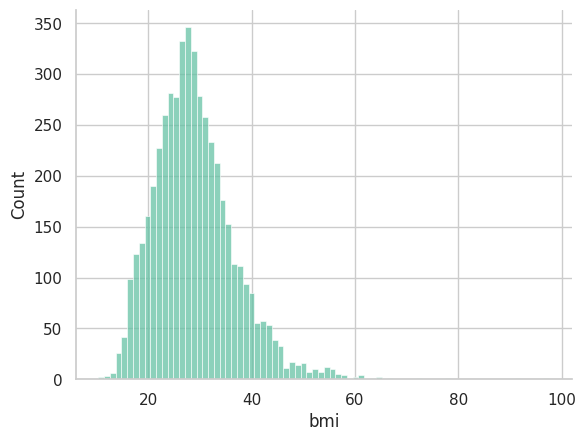

In [20]:
df['bmi'].isnull().sum()
df['bmi'].isnull().mean()
df['bmi'].describe()
sns.histplot(df['bmi'])


Eksik değer sayıları ve yüzdeleri:


,missing,percent
bmi,201,3.93


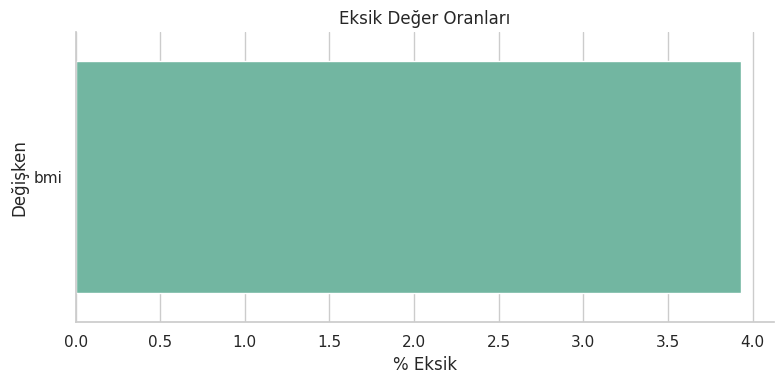

In [21]:
# 3) Eksik Değer Analizi
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df)).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'missing': missing_counts,
    'percent': (missing_pct * 100).round(2)
})

print('Eksik değer sayıları ve yüzdeleri:')
display(missing_df[missing_df['missing'] > 0])

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_df[missing_df['missing']>0]['percent'],
            y=missing_df[missing_df['missing']>0].index,
            orient='h', color='#66c2a5')
plt.xlabel('% Eksik')
plt.ylabel('Değişken')
plt.title('Eksik Değer Oranları')
plt.tight_layout()
plt.show()

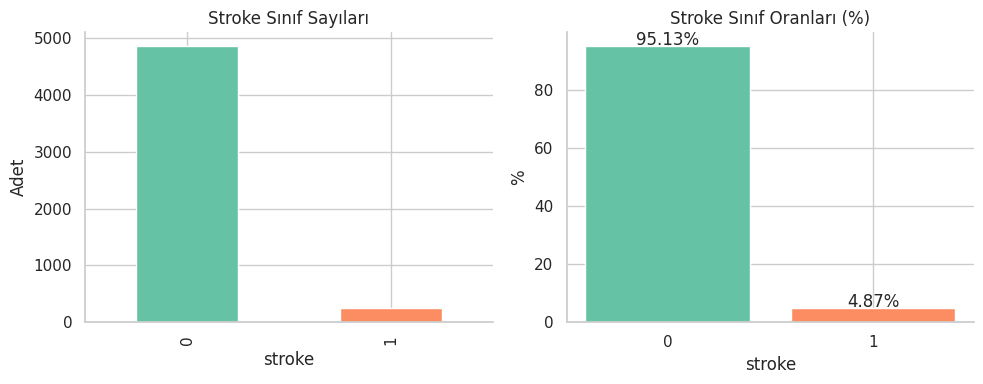

Sınıf oranları (%):
stroke
0   95.13
1    4.87
Name: count, dtype: float64


In [22]:
# 4) Hedef Değişken (stroke) Dağılımı
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vc = df['stroke'].value_counts().sort_index()
vc.plot(kind='bar', ax=ax[0], color=['#66c2a5', '#fc8d62'])
ax[0].set_title('Stroke Sınıf Sayıları')
ax[0].set_xlabel('stroke')
ax[0].set_ylabel('Adet')

ratio = (vc / vc.sum() * 100).round(2)
ax[1].bar(ratio.index.astype(str), ratio.values, color=['#66c2a5', '#fc8d62'])
ax[1].set_title('Stroke Sınıf Oranları (%)')
ax[1].set_xlabel('stroke')
ax[1].set_ylabel('%')
for i, v in enumerate(ratio.values):
    ax[1].text(i, v + 0.5, f"{v}%", ha='center')
plt.tight_layout()
plt.show()

print('Sınıf oranları (%):')
print(ratio)

İnme tahmininde bulunduğumuz için true positive'leri kaçırmamalıyız. Yani bütün true positiveleri yakalamamız ve false negative sayısını olabildiğince minimize etmemiz gerekiyor. Özetle Recall değerimizin 1'e olabildiğince olması gerek.

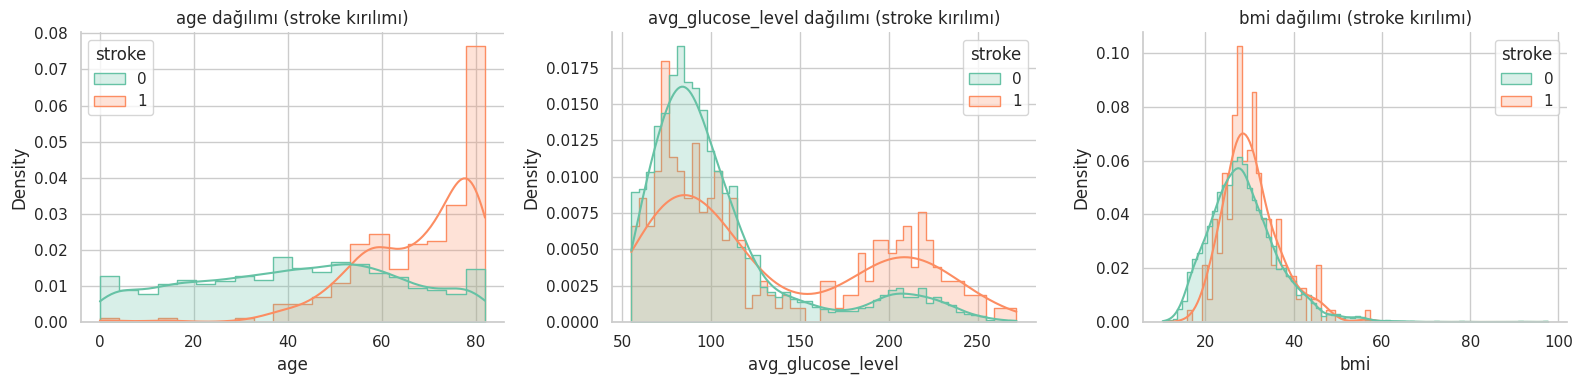

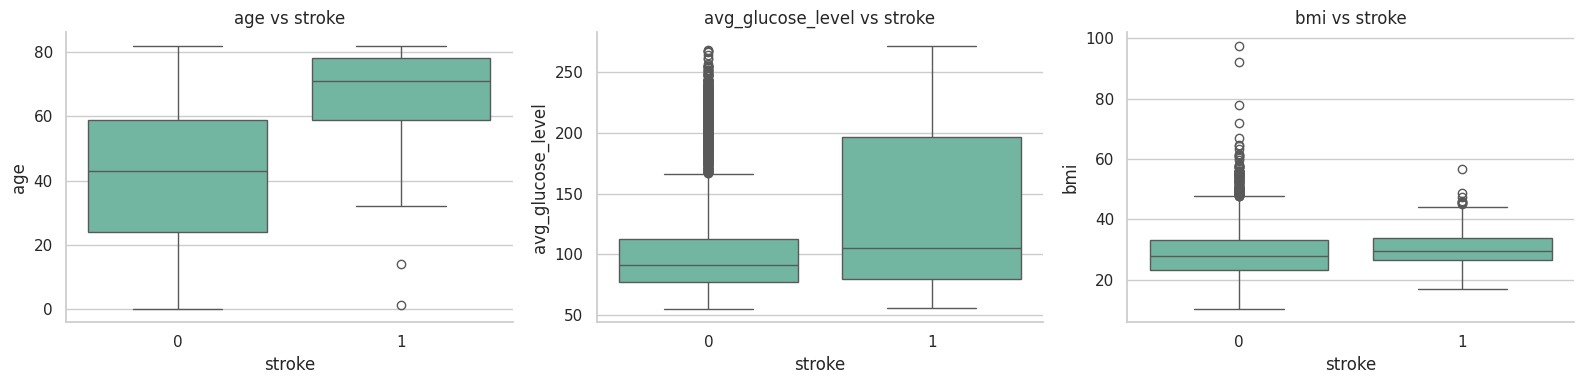

In [23]:
# 5) Sayısal Özelliklerin Dağılımları (age, avg_glucose_level, bmi)
num_cols = ['age', 'avg_glucose_level', 'bmi']

# Histogram + KDE (stroke kırılımında)
fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='stroke', element='step', stat='density',
                 common_norm=False, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} dağılımı (stroke kırılımı)')
plt.tight_layout()
plt.show()

# Boxplot (aykırı değer görünümü)
fig, axes = plt.subplots(1, len(num_cols), figsize=(16, 4))
for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='stroke', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs stroke')
plt.tight_layout()
plt.show()

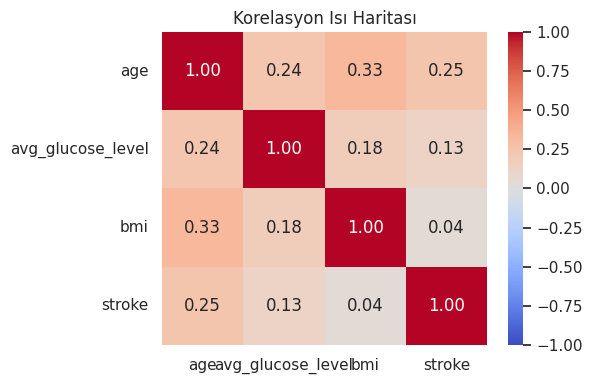

Stroke ile korelasyonlar:
stroke              1.00
age                 0.25
avg_glucose_level   0.13
bmi                 0.04
Name: stroke, dtype: float64


In [24]:
# 6) Korelasyon Isı Haritası (sayısal değişkenler + hedef)
num_cols = ['age', 'avg_glucose_level', 'bmi']
cols_for_corr = num_cols + ['stroke']
corr = df[cols_for_corr].corr(numeric_only=True)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Korelasyon Isı Haritası')
plt.tight_layout()
plt.show()

print('Stroke ile korelasyonlar:')
print(corr['stroke'].sort_values(ascending=False))

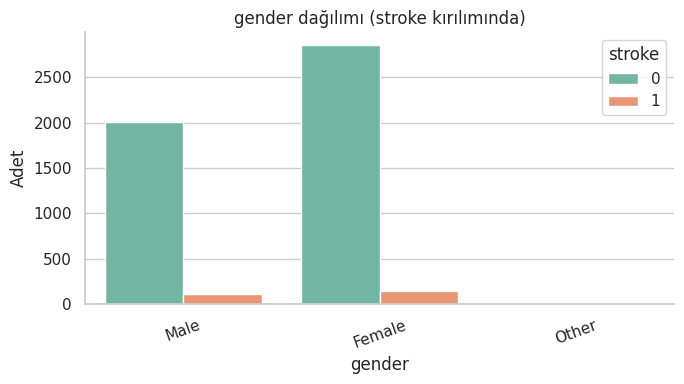

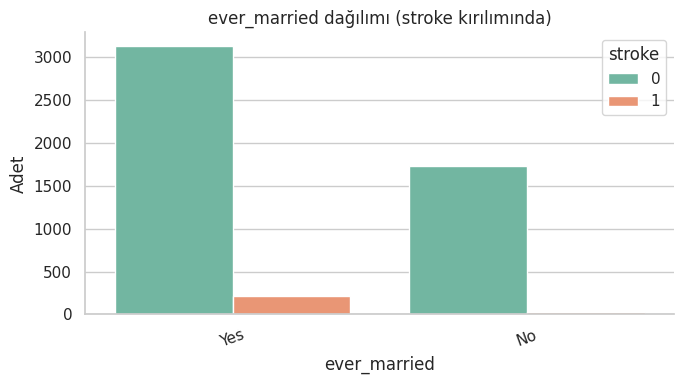

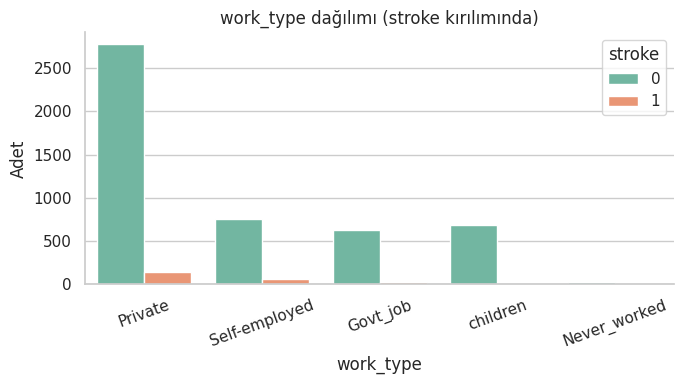

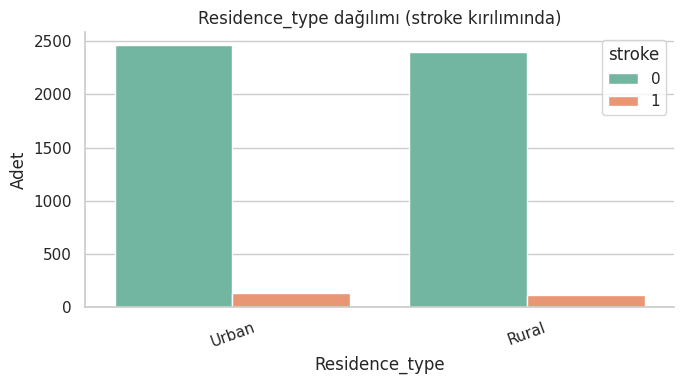

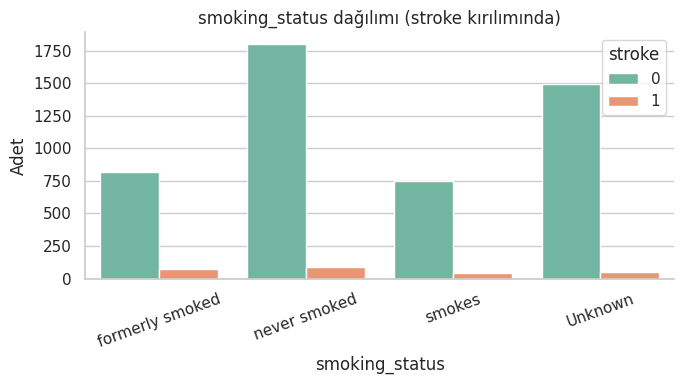

In [25]:
# 7) Kategorik Değişkenlerin Dağılımları (stroke kırılımı)
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in cat_cols:
    plt.figure(figsize=(7, 4))
    sns.countplot(data=df, x=col, hue='stroke')
    plt.title(f'{col} dağılımı (stroke kırılımında)')
    plt.xlabel(col)
    plt.ylabel('Adet')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()